# Align flu pacbio reads

This notebook imports, aligns and filters pacbio amplicons. 

In [1]:
import os
import warnings

from IPython.display import HTML, display

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

import pandas as pd

import numpy as np

import re

import plotnine as p9

In [2]:
warnings.simplefilter('ignore')

In [3]:
p9.theme_set(dms_variants.plotnine_themes.theme_graygrid())

Import snakemake variables

In [43]:
# amplicons = snakemake.input.amplicons
# features = snakemake.input.features
# plot_amplicons = snakemake.output.plot_amplicons
# plot_alignment = snakemake.output.plot_alignment
# ccs_report = snakemake.input.ccs_report
# ccs_fastq = snakemake.input.ccs_fastq
# runs = snakemake.params.runs
# amplicon_to_reference_df = snakemake.input.amplicon_to_reference_df
# alignment_stats = snakemake.params.alignment_stats
# threads = snakemake.threads

amplicons = "../data/flu_sequences/pacbio_amplicons/fluCA09.gb"
features = "../data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml"
plot_amplicons = "../results/pacbio/hashing_highMOI_amplicons.svg"
ccs_report = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt"
ccs_fastq = "../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs_fixterm.fastq.gz"
runs = ["hashing_highMOI_2020-10-20_all_segments_run1_ccs"]
alignment_stats= "../results/pacbio/CA09_align_and_parse"
amplicon_to_reference_df = "../data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv"
os.makedirs(alignment_stats, exist_ok=True)
threads=16

## Import target amplicons
Here we import target files for amplicons that where made using primers that either aligned to ends of flu sequences ('termini') or primers aligning approximately to the middle of a segment ('mid').

In [34]:
targetfile = amplicons

nlines_to_show = 100
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       HAmid                2123 bp ds-DNA     linear   SYN 05-NOV-2020
DEFINITION  HAmid
ACCESSION   HAmid
VERSION     .
KEYWORDS    .
SOURCE      HAmid
  ORGANISM  PCR product
FEATURES             Location/Qualifiers
     sequenced_ORF_1 1..870
     variant_tag_2    750
     viral_barcode    892..907
     polyA            1079..1107
     UMI              1108..1119
     cellbarcode      1120..1135
     Read1            1136..1155
     termini5         1156..1180
     termini3         871..1078
     sequenced_ORF_2 1261..2123
     variant_tag_1    1404
ORIGIN
        1 gctggatctg gtattatcat ttcagataca ccagtccacg attgcaatac aacttgtcaa
       61 acacccaagg gtgctataaa caccagcctc ccatttcaga atatacatcc gatcacaatt
      121 ggaaaatgtc caaaatatgt aaaaagcaca aaattgagac tggccacagg attgaggaat
      181 atcccgtcta ttcaatctag aggcctattt ggggccattg ccggtttcat tgaagggggg
      241 tggacaggga tggtagatgg atggtacggt tatcaccatc aaaatgagca ggggtcagga
      301 tatgcagccg acctgaagag cacacagaat gccat

Feature file defines features in amplicon genbank file. After splicing NEP mRNA ends up only containing a single variant tag, other segments have 2 tags. I don't think M segment primers capture M2 very well becasue part of the primers used to linearize M2 read overlap the 5' splice site and so don't align fully. I, therefore, did not include M2 amplicon reference/ 

In [35]:
feature_parse_specs_file = features
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 5
  query_clip3: 5
  termini5:
    filter:
      mutation_nt_count: 2
      mutation_op_count: null
    return: [mutations, accuracy]
  termini3:
    filter:
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_ORF_1:
    filter:
      clip5: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  sequenced_ORF_2:
    filter:
      clip3: 5
      mutation_nt_count: null
      mutation_op_count: 10
    return: [mutations, accuracy]
  polyA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 4
  UMI:
    return: [sequence, accuracy]
  cellbarcode:
    return: [sequence, accuracy]
  variant_tag_1:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
  variant_tag_2:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
    return: sequence
# defau

In [36]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags',
                                                 'default_1tag'],
                allow_extra_features=True,
                allow_clipped_muts_seqs=True)

Now let's plot all segment amplicons and save plots as a figure. 

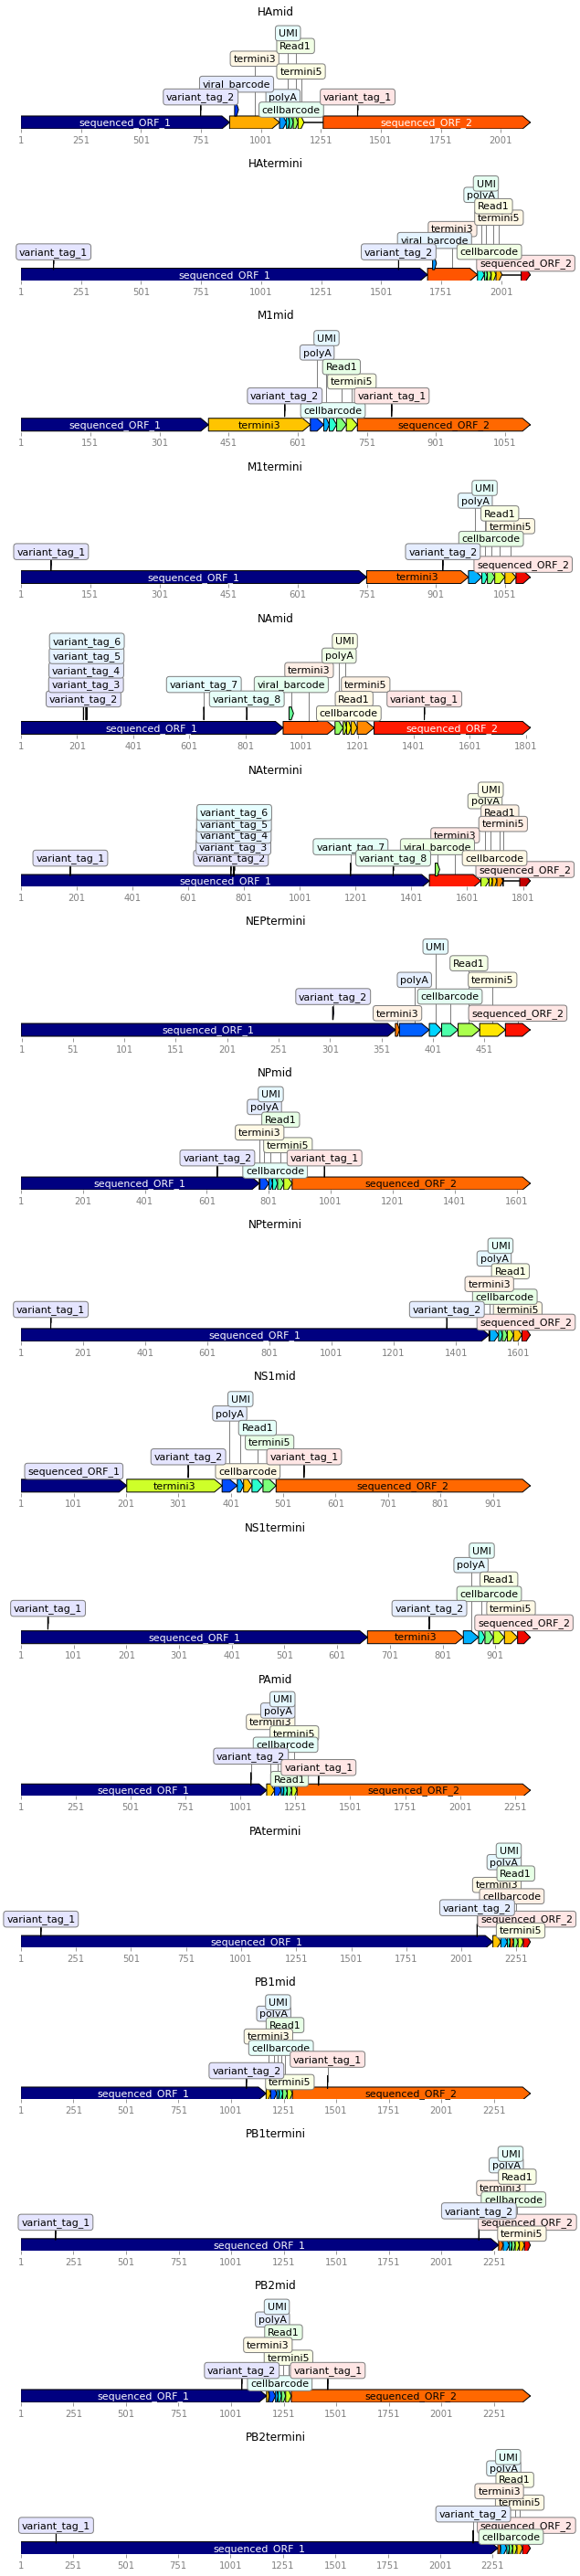

In [37]:
plot = targets.plot(ax_width=10)

In [38]:
print(f"Saving figure to {plot_amplicons}")
plot.savefig(plot_amplicons, format="svg")

Saving figure to ../results/pacbio/hashing_highMOI_amplicons.svg


## Align pacbio reads

Create packbio run dataframe

In [41]:
pacbio_runs = pd.DataFrame(
    {'name': runs, 'fastq': ccs_fastq, 'report': ccs_report}
)
display(HTML(pacbio_runs.to_html(index=False)))

name,fastq,report
hashing_highMOI_2020-10-20_all_segments_run1_ccs,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_ccs_fixterm.fastq.gz,../results/pacbio/hashing_highMOI_2020-10-20_all_segments_run1_report.txt


Now align all ccs to amplicons and filter for the ones that meet criteria defined in `fluCA09_features.yaml`.

Create an alignparse.minimap2.Mapper to run minimap2 with minimap [options](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_VIRUS_W_DEL) that allow for large deletions in viral sequences. 

In [49]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n"
      + ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


In [50]:
align_and_parse_outdir = os.path.join(alignment_stats)

In [51]:
readstats, aligned, filtered = targets.align_and_parse(
    df=pacbio_runs,
    mapper=mapper,
    outdir=align_and_parse_outdir,
    name_col='name',
    queryfile_col='fastq',
    overwrite=True,  # overwrite any existing output
    ncpus=threads,
)

Here are read alignment statistics telling how many reads have been aligned or filtered out for each reference amplicon.

In [52]:
readstats

,name,category,count
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAmid,3633
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAmid,11375
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered HAtermini,2171
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned HAtermini,4054
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered M1mid,405
5,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned M1mid,0
6,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered M1termini,3858
7,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned M1termini,10648
8,hashing_highMOI_2020-10-20_all_segments_run1_ccs,filtered NAmid,5457
9,hashing_highMOI_2020-10-20_all_segments_run1_ccs,aligned NAmid,14119


NameError: name 'plot_alignment' is not defined

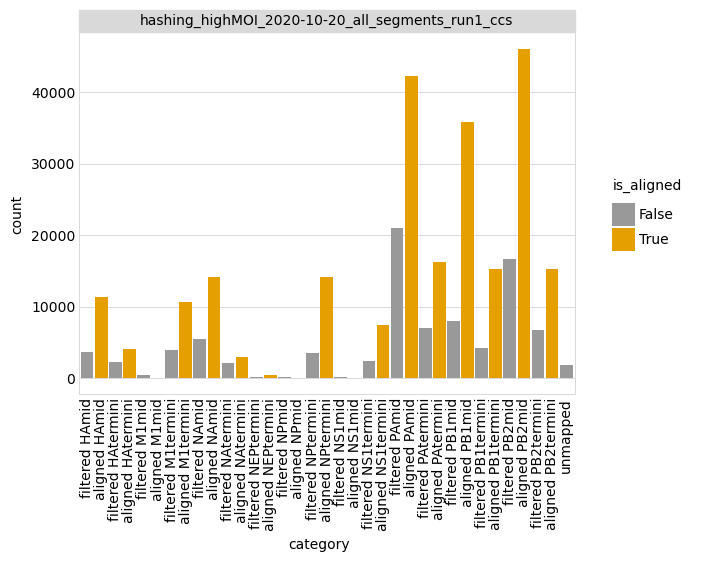

In [53]:
p = (
    p9.ggplot(readstats.assign(
        category=lambda x: pd.Categorical(x['category'],
                                          x['category'].unique(),
                                          ordered=True),
        is_aligned=lambda x: x['category'].str.contains('aligned'),),
        p9.aes('category', 'count', fill='is_aligned'))
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('~ name', nrow=1)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.scale_fill_manual(values=CBPALETTE)
)
_ = p.draw()

p9.ggsave(plot=p, filename=plot_alignment, verbose=False)

Now lets look at the most common reasons why some reads have been filtered out.

In [54]:
for target in targets.target_names[:1]:
    print(f"First few lines of `filtered` for {target}:")
    display(filtered[target].head())

First few lines of `filtered` for HAmid:


,name,query_name,filter_reason
0,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194761/ccs,query_clip5
1,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4194985/ccs,query_clip5
2,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260097/ccs,termini5 clip3
3,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4260187/ccs,sequenced_ORF_2 clip3
4,hashing_highMOI_2020-10-20_all_segments_run1_ccs,m54228_201020_194205/4325657/ccs,query_clip5


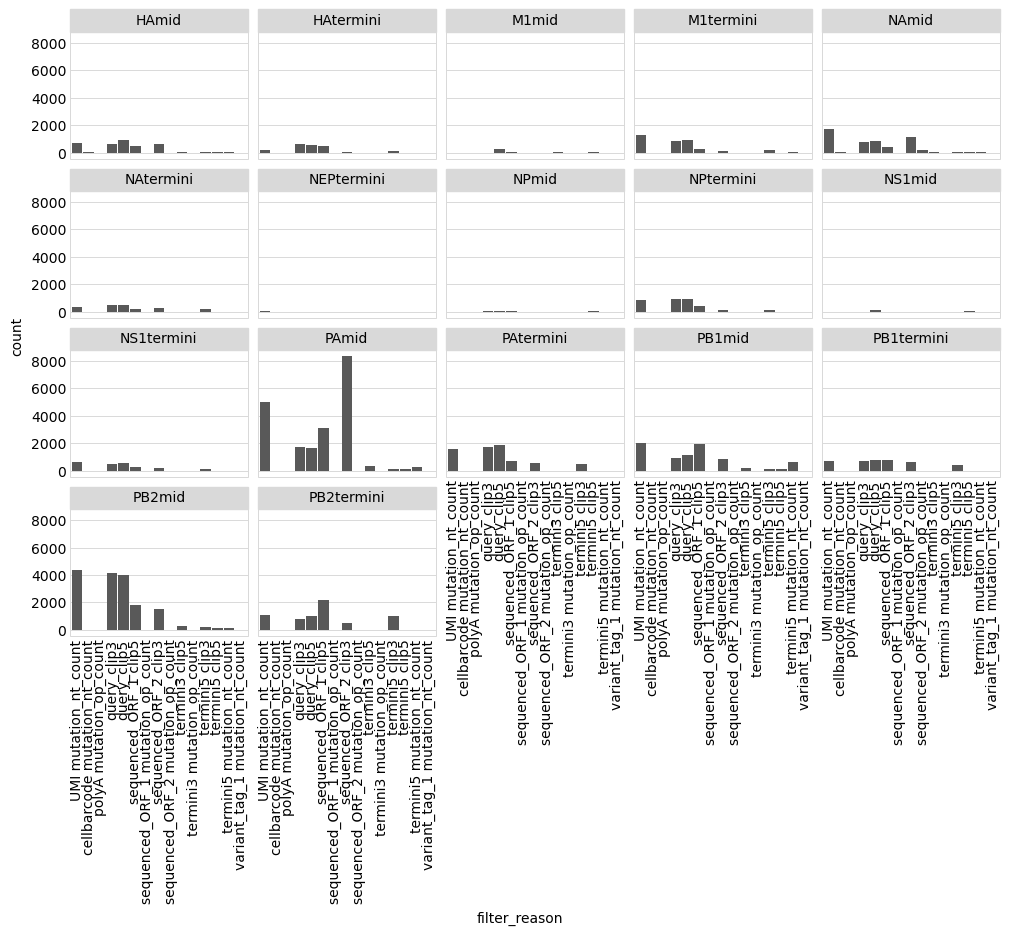

In [55]:
p = (
    p9.ggplot(pd.concat([df.assign(gene=gene) for gene, df
                         in filtered.items()])
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    x['gene'].unique(),
                                                    ordered=True)),
              p9.aes('filter_reason'))
    + p9.geom_bar()
    + p9.facet_wrap('~ gene', ncol=5)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               figure_size=(12, 8),
               panel_grid_major_x=p9.element_blank(),
               )
)
_ = p.draw()

## Convert amplicon sequence positions to wt

First we read in all alignment files

In [53]:
for run in runs:
    path = alignment_stats + '/' + run
    alignment_files = []
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and 'aligned' in i:
            alignment_files.append(path + '/' + i)
    
    amplicon_to_reference = pd.read_csv(amplicon_to_reference_df, na_filter=False)# Now lets read in 
                                                                                  # amplicon to reference 
                                                                                  # conversion file

    for alignment_file in alignment_files:
        print(alignment_file)
        af = pd.read_csv(alignment_file, na_filter=False)

        if af.empty:
            # in case some amplicons have no mutations print warning
            af_file = alignment_file.rsplit('/', 1)[-1]
            af_name = af_file.rsplit('_', 1)[0]
            print('no mutations found in '+ af_name)

        else:
            af_file = alignment_file.rsplit('/', 1)[-1]
            af_name = af_file.rsplit('_', 1)[0]
            reference = amplicon_to_reference.loc[(amplicon_to_reference['target'] == af_name),
                                  ["target","ORF_position",'sequenced_ORF_1',
                                   "sequenced_ORF_2","termini5","termini3"]]



            ap_features = ['sequenced_ORF_1',"sequenced_ORF_2"]

            for ap_feature in ap_features:
                
                
                # first we build a dictionary to find positions in reference sequence
                ref_dict = {} # empty dictionary for creating a reference lookup for each feature
                ref_site_mutation_list = [] # empty list for mutations that have been converted to reference numbering

                for (target, feature), df in reference.groupby(['target', ap_feature]):
                    df['ORF_position'] = df['ORF_position'].astype(str)
                    feature_num_to_orf_num_dict = (df
                                                   .query('target == @target')
                                                   .query(f'{ap_feature} == @feature')
                                                   .set_index(ap_feature)['ORF_position']
                                                   .to_dict()
                                                  )
                    ref_dict.update(feature_num_to_orf_num_dict)
                    
                if any(ref_dict) == 'FALSE':
                    break
                
                
                del ref_dict[''] # the first element in the dictionary is always an empty key
                                 # that should be deleted

                # here we use regex to change amplicon positions to positions in refrence 
                for index, row in af.iterrows():
                    feature_col = row[ap_feature + '_mutations']
                    dictionary = ref_dict
                    pattern = re.compile(r'(?<!\d)(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')(?!\d)')
                    result = pattern.sub(lambda x: dictionary[x.group()], feature_col)
                    ref_site_mutation_list.append(result)

                ref_site_mutation_df = pd.DataFrame(ref_site_mutation_list)
                af[ap_feature + '_reference'] = ref_site_mutation_df # attach reference-numbered mutations
                                                                     #
            af.to_csv(path + "/" + af_name + '_aligned_with_ref_annotation' + '.csv', index=False)



../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/PB1mid_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/NAtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/M1termini_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/PB2mid_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/PB1termini_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/NPmid_aligned.csv
no mutations found in NPmid
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/PB2termini_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/NPtermini_aligned.csv
../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/NS1mid_align

KeyError: ''

In [51]:
af = pd.read_csv("../results/pacbio/CA09_align_and_parse/hashing_highMOI_2020-10-20_all_segments_run1_ccs/NEPtermini_aligned.csv", na_filter=False)

my_list = list(af)
my_list

['query_name',
 'query_clip5',
 'query_clip3',
 'sequenced_ORF_1_mutations',
 'sequenced_ORF_1_accuracy',
 'sequenced_ORF_2_mutations',
 'sequenced_ORF_2_accuracy',
 'UMI_sequence',
 'UMI_accuracy',
 'cellbarcode_sequence',
 'cellbarcode_accuracy',
 'variant_tag_2_sequence']